In [1]:
# Test if GSM model can make one or more metabolites
import pandas as pd
import cobra
from cobra import Model, Reaction, Metabolite
from collections import OrderedDict
from copy import deepcopy
import os,sys
model_root_path = '../../../'
sys.path.append(model_root_path+'pycore/')
from gsm_custom_functions import *

#### Load data

In [2]:
curr_dir = os.getcwd()
# Metabolic model (COBRApy json)
model = cobra.io.load_json_model(curr_dir + '/../iRhtoC.json')
# model = cobra.io.load_json_model(curr_dir + '/../../../optional-extras/rt (kim et al. 2020)/Supplementary File S2/Rt_IFO0880.json')
# model = cobra.io.load_json_model('/Users/ejm6426/Downloads/iML1515.json')

In [4]:
# List of metabolites to check
metlist = ['lipopb_c']
# list of reactions to check (optional)
rxns_of_interest = ['LIPOS']
# model.reactions.SRC_lipoate_m.bounds = (0, 0.001)
print("demands", model.demands)
# max growth
print(model.objective)
model.optimize()

demands [<Reaction DM_amob_c at 0x318cee2b0>, <Reaction DM_5drib_c at 0x3264a4d00>, <Reaction DM_oxam_c at 0x32680a7f0>, <Reaction DM_aacald_c at 0x329f90640>, <Reaction DM_4crsol_c at 0x32bc38610>, <Reaction DM_mththf_c at 0x32e807d30>]
Maximize
1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685


,fluxes,reduced_costs
CYTDK2,0.00000,0.000000
XPPT,0.00000,-0.015047
HXPRT,0.00000,-0.015047
NDPK5,0.00000,-0.000000
SHK3Dr,0.33424,0.000000
...,...,...
MPTS,0.00000,0.000000
MOCOS,0.00000,0.000000
BMOGDS2,0.00000,0.000000
FESD2s,0.00000,0.000000


In [4]:
model.reactions.EX_glc__D_e.lower_bound = -1.353245177 # glucose uptake
# fix growth rate
model.reactions.BIOMASS.upper_bound = 0.1
model.medium

AttributeError: DictList has no attribute or entry BIOMASS

# Check each metabolite and show all rxns involved in its production

In [5]:
# medium
model.reactions.EX_ca2_e.lower_bound = -1000
model.reactions.EX_cl_e.lower_bound = -1000
model.reactions.EX_cu2_e.lower_bound = -1000
model.reactions.EX_fe2_e.lower_bound = -1000
model.reactions.EX_fe3_e.lower_bound = -1000
model.reactions.EX_k_e.lower_bound = -1000
model.reactions.EX_mg2_e.lower_bound = -1000
model.reactions.EX_mn2_e.lower_bound = -1000
model.reactions.EX_na1_e.lower_bound = -1000
model.reactions.EX_nh4_e.lower_bound = -1000
model.reactions.EX_ni2_e.lower_bound = -1000
model.reactions.EX_so4_e.lower_bound = -1000
model.reactions.EX_zn2_e.lower_bound = -1000
model.reactions.EX_pi_e.lower_bound = -1000
model.reactions.EX_thm_e.lower_bound = -1000
model.reactions.EX_ribflv_e.lower_bound = -1000
model.reactions.EX_nac_e.lower_bound = -1000
model.reactions.EX_pydxn_e.lower_bound = -1000
model.reactions.EX_fol_e.lower_bound = -1000
model.reactions.EX_pnto__R_e.lower_bound = -1000
model.reactions.EX_4abz_e.lower_bound = -1000
model.reactions.EX_inost_e.lower_bound = -1000
model.reactions.EX_o2_e.lower_bound = -1000
model.reactions.EX_btn_c.lower_bound = -1000
model.reactions.EX_cobalt2_e.lower_bound = -1000
model.reactions.EX_h_e.lower_bound = -1000
model.reactions.EX_h2o_e.lower_bound = -1000

AttributeError: DictList has no attribute or entry EX_ni2_e

In [5]:
# check if rxns of interest can carry flux
for rxn in rxns_of_interest:
    print(rxn, str(model.reactions.get_by_id(rxn).reaction))
    # check mass balance
    print('mass balance:'+str(check_mass_balance_cobra(rxn,model)))
    with model as model:
        model.objective = rxn
        model.objective.direction = 'max'
        solution_max = model.optimize()
        # try other direction
        model.objective.direction = 'min'
        solution_min = model.optimize()
        print(rxn, solution_min.objective_value, solution_max.objective_value)

LIPOS 4fe4s_c + 2.0 amet_c + h_c + nad_c + octapb_c --> 2fe2s_c + 2.0 dad_5_c + 2.0 fe2_c + lipopb_c + 2.0 met__L_c + nadh_c
mass balance:OrderedDict([('S', 0.0), ('Fe', 0.0), ('C', 0.0), ('H', 0.0), ('N', 0.0), ('O', 0.0), ('P', 0.0), ('charge', 0.0)])
LIPOS 0.0 0.0


In [6]:
GAMS_rxn_list = []
GAMS_stoich_list = []
Fsolutions = []
IFsolutions = []
max_yield = dict()
with model: #to prevent unintended edits
    for met in metlist:
        # Create demand rxn for each metabolite (automatically made irreversible)
        model.add_boundary(model.metabolites.get_by_id(met), type="demand")
        # print GAMS versions of new rxn name and stoich
        GAMS_rxn_list.append("'DM_"+met+"'")
        GAMS_stoich_list.append("'MET-"+met+"'.'"+"DM_"+met+"' -1")
        model.objective = model.reactions.get_by_id("DM_"+met) # Maximize demand flux
        model.objective_direction = "max"
        print("Objective: ",model.objective)
        fba = model.optimize()
        print(fba)
        if fba.objective_value == 0:
            # in case rxn flux can only be non-positive, minimize to check for nonzero fluxes
            model.objective_direction = "min"
            fba = model.optimize()
            print(fba)
            if fba.objective_value == 0:
                # add to list of unusable metabolites
                IFsolutions.append(met)
                # check if rxns of interest are active
                for rxn in rxns_of_interest:
                    if model.reactions.get_by_id(rxn).flux != 0:
                        print("Reaction of interest: ",rxn)
                        print(str(model.reactions.get_by_id(rxn).summary()))
            else:
                # note rxn and objective value
                Fsolutions.append(met)
                print(str(model.metabolites.get_by_id(met).summary()))
        else: 
            max_yield[met] = model.reactions.get_by_id("DM_"+met).flux
            # add to list of usable metabolites
            Fsolutions.append(met)
            print(str(model.metabolites.get_by_id(met).summary()))
    print("Metabolites that can be made: ",Fsolutions)
    print("Metabolites that can NOT be made: ",IFsolutions)

Objective:  Maximize
1.0*DM_lipopb_c - 1.0*DM_lipopb_c_reverse_c3e46
<Solution 0.000 at 0x32eb85160>
lipopb_c
Formula: C8H13OS2

Producing Reactions
-------------------
Percent      Flux Reaction                                                                      Definition
100.00% 2.456E-05    LIPOS 4fe4s_c + 2.0 amet_c + h_c + nad_c + octapb_c --> 2fe2s_c + 2.0 dad_5_c + 2....

Consuming Reactions
-------------------
Percent       Flux    Reaction    Definition
100.00% -2.456E-05 DM_lipopb_c lipopb_c --> 
Metabolites that can be made:  ['lipopb_c']
Metabolites that can NOT be made:  []


In [7]:
# find all rxns used during fba
rxns_used = []
for rxn in model.reactions:
    if fba.fluxes[rxn.id] != 0:
        rxns_used.append(rxn.id)
print("Reactions used: ",rxns_used)
# print number of rxns used
print("Number of reactions used: ",len(rxns_used))
# print rxns with negative flux
rxns_neg = []
for rxn in model.reactions:
    if fba.fluxes[rxn.id] < 0:
        rxns_neg.append(rxn.id)
print("Reactions with negative flux: ",rxns_neg)

Reactions used:  ['SHK3Dr', 'DHORTS', 'OMPDC', 'G5SD', 'CS', 'ICDHyr', 'PPA', 'APRAUR', 'TRPAS2', 'DB4PS', 'ALAR', 'RBFK', 'PPM', 'ASPTA', 'RBFSb', 'EX_pi_e', 'SHCHD2', 'EX_co2_e', 'A5PISO', 'PMDPHT', 'CPPPGO', 'ILETA', 'DHORD5', 'VALTA', 'IPPMIb', 'ORPT', 'RBFSa', 'ACHBS', 'DHAD2', 'ACLS', 'PSCVT', 'ANS', 'FRD2', 'ANPRT', 'CHORM', 'PTAr', 'CHORS', 'IGPS', 'ACKr', 'LEUTAi', 'EX_h_e', 'DMATT', 'GRTT', 'UPP3S', 'UPPDC1', 'EX_mn2_e', 'MOAT', 'UDCPDPS', 'ECOAH6', 'USHD', 'ENO', 'FBA', 'HCO3E', 'IMPC', 'IMPD', 'ECOAH4', 'LPADSS', 'GLUTRS', 'TDSK', 'PGI', 'TMPPP', 'PGK', 'PGL', 'RPE', 'DHQTi', 'IPMD', 'AIRC3', 'TALA', 'PUNP1', 'ADSL2r', 'TKT1', 'EX_fe2_e', 'TMDS', 'PPCDC', 'EX_glc__D_e', 'DHAD1', 'IPPMIa', 'MDH', 'FUM', 'FMNAT', 'OHPBAT', 'KARA1', 'KARA2', 'ACCOAC', 'NADK', 'GLUTRR', 'HACD6', 'ECOAH1', 'ECOAH2', 'ARGSS', 'AGPR', 'G1SAT', 'KDOCT2', 'ECOAH3', 'DXPS', 'CDPMEK', 'MECDPS', 'PGAMT', 'UAGDP', 'UAGCVT', 'GLUR', 'GLYCL', 'NNDPR', 'PPC', 'HACD4', 'EX_zn2_e', 'HACD5', 'HACD7', 'DNMPPA'

No reactants provided as stopping points; using medium metabolites
Paths from  pi_e  to  lipopb_c
Paths from  pi_e  to  pi_p
Node not found: co2_e or pi_p
Node not found: fe3_e or pi_p
No path from mn2_e to pi_p
No path from fe2_e to pi_p
No path from glc__D_e to pi_p
No path from zn2_e to pi_p
No path from mg2_e to pi_p
No path from ca2_e to pi_p
No path from ni2_e to pi_p
No path from cu2_e to pi_p
Node not found: sel_e or pi_p
No path from cobalt2_e to pi_p
No path from mobd_e to pi_p
No path from so4_e to pi_p
No path from nh4_e to pi_p
No path from k_e to pi_p
Node not found: na1_e or pi_p
No path from cl_e to pi_p
No path from o2_e to pi_p
Node not found: tungs_e or pi_p
Node not found: slnt_e or pi_p
Paths from  pi_e  to  pi_c
Node not found: co2_e or pi_c
Node not found: fe3_e or pi_c
Paths from  mn2_e  to  pi_c
No path from pi_e to mn2_p
Node not found: co2_e or mn2_p
Node not found: fe3_e or mn2_p
Paths from  mn2_e  to  mn2_p
No path from fe2_e to mn2_p
No path from glc__D_e 

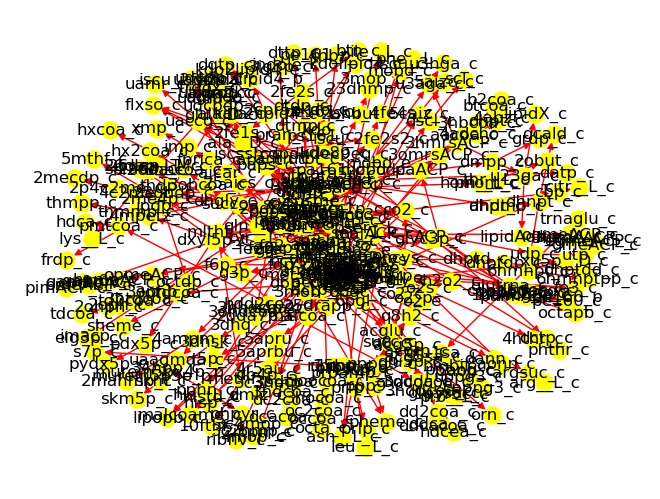

In [46]:
import networkx as nx
import random
from networkx import Graph
import numpy as np
medium_mets = list(i.replace('EX_','') for i in model.medium.keys() if 'EX_' in i and model.medium[i] != 0)
# don't have specific compounds in mind, just want to see what can make the product(s)
target_reactants = [] 
product_sources = [] # compounds from medium or target_reactants that can make the product(s)
target_products = ['lipopb_c']
# force graph to use the same random seed
seed = 1
np.random.seed(seed)
# Create a directed graph
G = nx.DiGraph()

fluxdata = pd.DataFrame(fba.fluxes.items(), columns=['rxn','flux'])

# only show rxns used
rxns_to_consider = [r for r in model.reactions if r.id in rxns_used]
excluded_mets = ['H2O','WATER','H','H+','PROTON','ATP','ADP','AMP','NADH','NADPH','NAD+','NADP+','NAD','NADP','NADH2','NADPH2','NADP(+)','NADP(H)','NAD(H)','NAD(P)H','NAD(P)','FAD','FADH2','FMN','FMNH2']

def met_is_excluded(met):
    if met.id in excluded_mets or met.name in excluded_mets:
        return True
    elif met.annotation.get('biocyc') is not None and len(set(met.annotation.get('biocyc')).intersection(set(['META:'+i for i in excluded_mets]))) > 0:
        return True
    else:
        return False

if target_reactants == []:
    target_reactants = [i for i in medium_mets if not(met_is_excluded(model.metabolites.get_by_id(i)))]
    print("No reactants provided as stopping points; using medium metabolites")
# start with rxns making target products, and find all rxns that make their precursors until all no more precursors can be found
# for product in target_products:
#     for rxn in model.metabolites.get_by_id(product).reactions:
#         if rxn in rxns_to_consider:
#             reactants,products = [rxn.reactants,rxn.products] if fluxdata[fluxdata.rxn == rxn.id].flux.values[0] > 0 else [rxn.products,rxn.reactants]
#             # make edge from reactants to products
#             for reactant in reactants:
#                 if reactant.id not in excluded_mets:
#                     G.add_edge(reactant.id,product,label=rxn.id)
#                     product_sources.append(reactant.id)

# rxns_checked = set()
# for source in product_sources:
#     # find all sources of sources until no more sources can be found
#     while True:
#         new_sources = []
#         for product in target_products:
#             for rxn in model.metabolites.get_by_id(source).reactions:
#                 if rxn.id in rxns_checked:
#                     continue
#                 reactants,products = [rxn.reactants,rxn.products] if fluxdata[fluxdata.rxn == rxn.id].flux.values[0] > 0 else [rxn.products,rxn.reactants]
#                 # make edge from reactants to products
#                 for reactant in reactants:
#                     if reactant.id not in excluded_mets and reactant.id != source:
#                         rxns_checked.add(rxn.id)
#                         # G.add_edge(reactant.id,source,LabelGraphics=[ text  "+rxn.id+" ])
#                         G.add_edge(reactant.id,source,label=rxn.id)
#                         # add "edge-label" attribute to 
#                         # print("Adding edge",rxn,"from",reactant.id,"to",source)
#                         new_sources.append(reactant.id)
#         if len(new_sources) == 0:
#             break
#         else:
#             source = new_sources[0]

for r in rxns_to_consider:
    reactants,products = [r.reactants,r.products] if fluxdata[fluxdata.rxn == r.id].flux.values[0] > 0 else [r.products,r.reactants]
    for product in products:
        for reactant in reactants:
            if not(met_is_excluded(reactant)) and not(met_is_excluded(product)):
                G.add_edge(reactant.id,product.id,label=r.id)
# check all nodes and remove any that have no path to target products
for node in list(G.nodes):
    if not nx.has_path(G,node,target_products[0]):
        G.remove_node(node)
# remove all self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# for rxn in rxns_to_consider:
# 	products,reactants = [rxn.products,rxn.reactants] if fluxdata[fluxdata.rxn == rxn.id].flux.values[0] > 0 else [rxn.reactants,rxn.products]
# 	for product in products:
#         # make edge from reactants to products
# 		for reactant in reactants:
# 			G.add_edge(reactant.id,product.id,rxn=rxn)

# show pathways that lead to lipopb_c from mets in medium
paths = set()
# make a new digraph with all nodes from G for the shortest pathways between target reactants and target products
G2 = nx.DiGraph()

mets_checked = set()
def simplest_pathway(target_products,possible_reactants,mets_checked_parameter):
    global mets_checked
    for product in target_products:
        mets_checked.add(product)
        for reactant in possible_reactants:
            mets_checked.add(reactant)
            try: 
                # find shortest path from met to target_products; include edge names in path
                newpaths = [nx.shortest_path(G, source=reactant, target=product)]
                # find edge names in path
                edgepath = []
                # if any paths are found, add to set
                print("Paths from ",reactant," to ",product)
                for path in newpaths:
                    for i in range(len(path)-1):
                        edgepath.append(G[path[i]][path[i+1]]['label'])
                        G2.add_edge(path[i],path[i+1],label=G[path[i]][path[i+1]]['label'])
                        # find all reactants in each rxn on the path
                        r = model.reactions.get_by_id(G[path[i]][path[i+1]]['label'])
                        reactants,products = [r.reactants,r.products] if fluxdata[fluxdata.rxn == r.id].flux.values[0] > 0 else [r.products,r.reactants]
                        for reactant in reactants:
                            if not(met_is_excluded(reactant)) and reactant.id not in possible_reactants and reactant.id not in mets_checked:
                                simplest_pathway([reactant.id],possible_reactants,mets_checked)
                    # print(edgepath)
                    # paths.add(str(path))
                    # # add to new graph
                    # for i in range(len(path)-1):
                    #     G2.add_edge(path[i],path[i+1],label=G[path[i]][path[i+1]]['label'])
                    # if any other reactants are present and haven't been checked, repeat process
                    # for node in path:
                    #     if node not in mets_checked:
                    #         mets_checked.add(node)
                    #         simplest_pathway([node],target_reactants,mets_checked)
            except nx.NetworkXNoPath:
                print("No path from",reactant,"to",product)
            except nx.NodeNotFound:
                print("Node not found:",reactant,"or",product)
            # except MaximumRecursionError:
            #     print("Maximum recursion error")
    return G2
import sys
sys.setrecursionlimit(len(model.metabolites))
simplest_pathway(target_products,target_reactants,mets_checked)
# export as gml
filename="pathways-making-"+target_products[0]
nx.write_gml(G, filename+".gml",stringizer=lambda x: str(x))
filename="pathways-making-"+target_products[0]+"-simplified"
nx.write_gml(G2, filename+".gml",stringizer=lambda x: str(x))
for graph in [G2]:
    nx.draw(graph, with_labels=True, node_color='yellow', edge_color='red',node_size=150)
    # draw edge labels
    edge_labels = nx.get_edge_attributes(graph,'rxn')
    nx.draw_networkx_edge_labels(graph, pos=nx.spring_layout(graph), edge_labels=edge_labels)
    print("Nodes: ",graph.number_of_nodes())
    print("Edges: ",graph.number_of_edges())
# nx.write_gexf(G, filename+".gexf")
# for product in target_products:
#     for reactant in target_reactants:
#         try: 
#             # find 1 path from met to target_products; include edge names in path
#             newpaths = nx.all_simple_paths(G, source=reactant, target=product)
#             # newpaths = nx.all_simple_paths(G, source=reactant, target=product)
#             # find edge names in path
#             edgepath = []
#             # if any paths are found, add to set
#             print("Paths from ",reactant," to ",product)
#             for path in newpaths:
#                 for i in range(len(path)-1):
#                     edgepath.append(G[path[i]][path[i+1]]['rxn'])
#                 print(edgepath)
#                 paths.add(path)
#         except nx.NetworkXNoPath:
#             print("No path from ",reactant," to ",product)

In [8]:
print("Max yields: ",max_yield)
print("GAMS_rxn_list: ")
for i in GAMS_rxn_list:
    print(i)
print("GAMS_stoich_list: ")
for i in GAMS_stoich_list:
    print(i)

Max yields:  {}
GAMS_rxn_list: 
'DM_zymstest_RT_rm'
'DM_lnlncgcoa_rm'
GAMS_stoich_list: 
'MET-zymstest_RT_rm'.'DM_zymstest_RT_rm' -1
'MET-lnlncgcoa_rm'.'DM_lnlncgcoa_rm' -1
